Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from random import randint
import warnings

# Suppress future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Loading Valorant Dataset

In [2]:
val = pd.read_csv("val_stats.csv",  low_memory=False)
df = val.copy()
df.head()

,region,name,tag,rating,damage_round,headshots,headshot_percent,aces,clutches,flawless,...,gun2_name,gun2_head,gun2_body,gun2_legs,gun2_kills,gun3_name,gun3_head,gun3_body,gun3_legs,gun3_kills
0,NaN,ShimmyXD,#NA1,Radiant,135.8,992,24.9,0,140,80,...,Phantom,33,62,5,220,Classic,36,60,3,147
1,NaN,XSET Cryo,#cells,Radiant,170.3,879,28.3,2,122,94,...,Operator,8,91,0,226,Phantom,32,63,5,137
2,NaN,PuRelittleone,#yoruW,Radiant,147.5,720,24.0,3,117,59,...,Phantom,36,61,3,231,Operator,8,91,1,102
3,NaN,Boba,#0068,Radiant,178.2,856,37.3,3,83,49,...,Sheriff,48,51,1,48,Phantom,44,56,0,36
4,NaN,i love mina,#kelly,Radiant,149.8,534,24.4,2,71,38,...,Spectre,21,71,8,65,Operator,8,92,0,64


Preprocessing

In [3]:
# Combine username and tag into a single column
df['username'] = df['name'] +" "+ df['tag']
df.drop(["region", "name", "tag"], axis = 1, inplace = True)
# Remove commas from numerical columns 
df = df.replace(',', '', regex=True)
df.head()

,rating,damage_round,headshots,headshot_percent,aces,clutches,flawless,first_bloods,kills,deaths,...,gun2_head,gun2_body,gun2_legs,gun2_kills,gun3_name,gun3_head,gun3_body,gun3_legs,gun3_kills,username
0,Radiant,135.8,992,24.9,0,140,80,161,1506,1408,...,33,62,5,220,Classic,36,60,3,147,ShimmyXD #NA1
1,Radiant,170.3,879,28.3,2,122,94,316,1608,1187,...,8,91,0,226,Phantom,32,63,5,137,XSET Cryo #cells
2,Radiant,147.5,720,24.0,3,117,59,216,1115,1064,...,36,61,3,231,Operator,8,91,1,102,PuRelittleone #yoruW
3,Radiant,178.2,856,37.3,3,83,49,235,1134,812,...,48,51,1,48,Phantom,44,56,0,36,Boba #0068
4,Radiant,149.8,534,24.4,2,71,38,137,869,781,...,21,71,8,65,Operator,8,92,0,64,i love mina #kelly


Feature Definition

In [4]:
categorical_columns = ["agent_1", "agent_2","agent_3", "gun1_name", "gun2_name", "gun3_name" ]

numerical_columns = ["damage_round", "headshots", "headshot_percent", "aces", "clutches", "flawless", "first_bloods", "kills",
                     "deaths","assists", "kd_ratio", "most_kills", "score_round", "wins","win_percent", "gun1_head", "gun1_body",
                    "gun1_legs","gun1_kills","gun2_head", "gun2_body","gun2_legs","gun2_kills", "gun3_head", "gun3_body",
                    "gun3_legs","gun3_kills"]

ranks = ["Unrated","Iron 1", "Iron 2", "Iron 3","Bronze 1", "Bronze 2", "Bronze 3","Silver 1", "Silver 2", "Silver 3",
    "Gold 1", "Gold 2", "Gold 3","Platinum 1", "Platinum 2", "Platinum 3","Diamond 1", "Diamond 2", "Diamond 3",
    "Ascendant 1", "Ascendant 2", "Ascendant 3","Immortal 1", "Immortal 2", "Immortal 3","Radiant"
]


Preprocessing Transformers

In [5]:
# Imputation transformer
imputer = SimpleImputer(strategy='mean') # or 'median', 'most_frequent'

# Encoding transformer
encoder = OneHotEncoder(handle_unknown='ignore')
ordinalencoder = OrdinalEncoder(categories=[ranks])
ordinalencoder.fit(df[['rating']])

# Scaling transformer
scaler = StandardScaler()


def dynamic_column_selector(column_names):
    def column_selector(X):
        return [col for col in column_names if col in X.columns]
    return column_selector



# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, dynamic_column_selector(numerical_columns)),
        ('cat', encoder, dynamic_column_selector(categorical_columns)),
        ('impute', imputer, dynamic_column_selector(numerical_columns)),
    ])


Pipelines

In [6]:
# Creating Pipeline for each Model separately
pipe_dt = Pipeline([('preprocessor', preprocessor), ('DT', DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('RF', RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('preprocessor', preprocessor), ('KNN', KNeighborsClassifier())])
pipe_lasso = Pipeline([('preprocessor', preprocessor), ('Lasso', Lasso(random_state=42, alpha=0.5))])

 Data Splitting

In [7]:
# Dividing Data into Training and Testing Dataset
X = df.drop('rating', axis=1)
y = ordinalencoder.transform(df[['rating']]).ravel()
#Creating a ordinal column for Categorical Column "rating" in df
df["rating_num"] = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Finding the maxiumum corelation between rating and other stats
cor = df.corrwith(df['rating_num'])
cor2 = cor.drop(cor.index[-1])
cor2.max()

0.369982202133165

In [9]:
#This is very low correlation, further this information would help us proof that stats can not determine player's rank.

Model Training and Testing

DECISION TREE
Predicted Values: [23. 22. 24. 22. 22.]
Actual Values: [23. 22. 22. 22. 23.]
Decision Tree MAE: 0.66
Decision Tree RMSE: 1.15
Accuracy: 52.14%


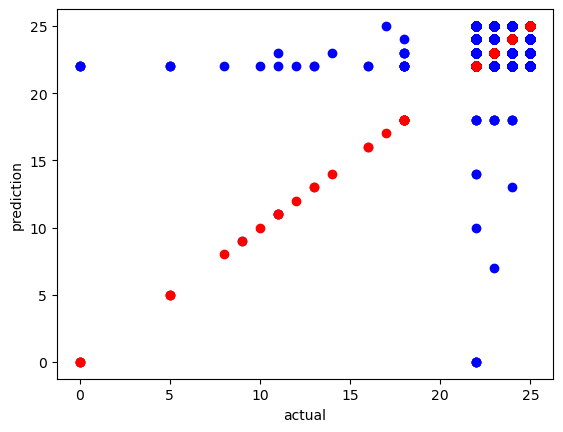



RANDOM FOREST
Predicted Values: [23. 22. 22. 22. 22.]
Actual Values: [23. 22. 22. 22. 23.]
Random Forest MAE: 0.54
Random Forest RMSE: 1.0
Accuracy: 60.42%


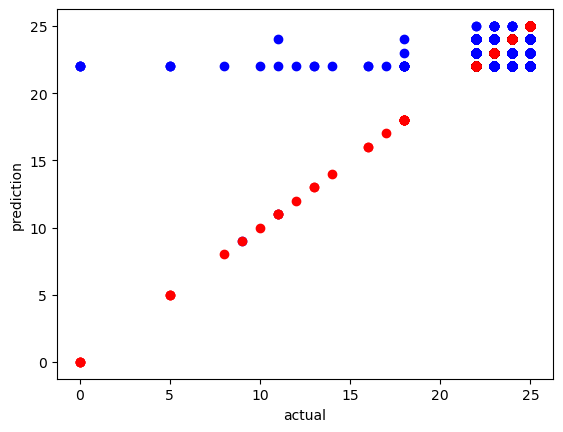



K-NEAREST NEIGHBORS
Predicted Values: [22. 22. 23. 22. 22.]
Actual Values: [23. 22. 22. 22. 23.]
K-Nearest Neighbors MAE: 0.59
K-Nearest Neighbors RMSE: 1.06
Accuracy: 56.39%


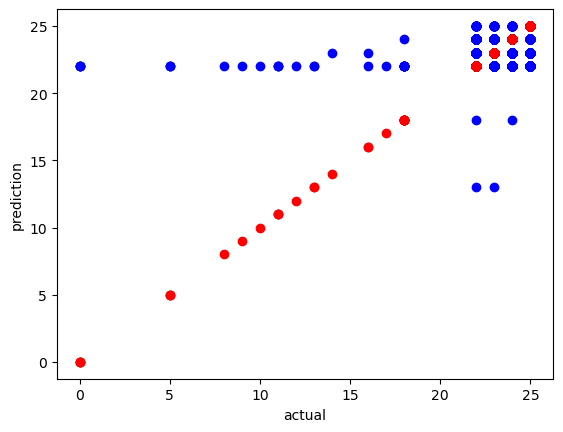



LASSO
Predicted Values: [22.57557298 22.21208411 22.36248174 22.26003738 22.33462795]
Actual Values: [23. 22. 22. 22. 23.]
LASSO MAE: 0.61
LASSO RMSE: 0.87


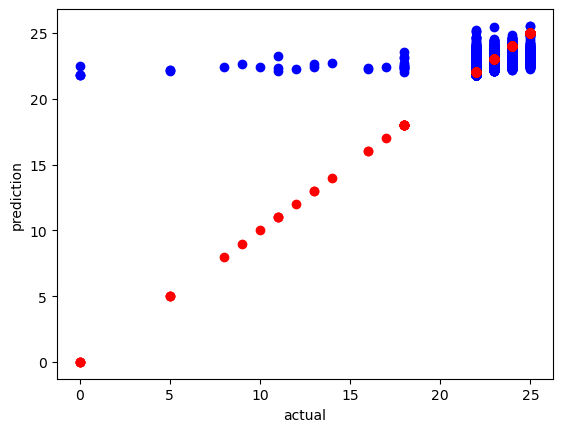

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

models = [pipe_dt, pipe_rf, pipe_knn, pipe_lasso]
model_names = ['Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'LASSO']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name.upper())
    print(f"Predicted Values: {y_pred[:5]}")
    print(f"Actual Values: {y_test[:5]}")
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} MAE: {round(mae, 2)}")
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} RMSE: {round(rmse, 2)}")
    if(name != "LASSO"):
        acc = accuracy_score(y_test, y_pred)*100
        print(f"Accuracy: {round(acc, 2)}%")
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.scatter(y_test, y_test, color='red', label='Actual')
    
    plt.xlabel("actual")
    plt.ylabel("prediction")
    plt.show()
    print("\n")


The scatter plots suggest a concentration of accurate predictions within the range of Radiant to Ascendant 1 (20-25 on the ranking scale)

Trained multiple models (Decision Tree, Random Forest, KNN, LASSO) to predict player rank using stats.
Random Forest performed best (60.42% accuracy), but the correlation between stats and rank was moderate (0.369).
This suggests it's difficult to predict rank with high accuracy due to missing factors (game sense, teamwork) and limitations of the rank system itself.

Hyper Parameter Optimization

In [ ]:
# Random Forest Optimization

In [20]:
# hyperparameter for Ranndom Forest 
rf_params = {
    'RF__n_estimators': [100, 200],  # Number of trees (random int)
    'RF__max_depth': [3, 5],        # Maximum depth (random int)
    'RF__max_features': ['auto', 'sqrt', 'log2']  # Feature consideration (choice)
}

# Set the number of random parameter sets to explore (n_iter)
n_iter_search = 100 

random_search_rf = RandomizedSearchCV(
    pipe_rf, rf_params, n_iter=n_iter_search, cv=5, scoring="accuracy", verbose=2
)

# Fit the RandomizedSearchCV model to your training data
random_search_rf.fit(X_train, y_train)

C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   9.5s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=  10.3s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   9.9s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   9.7s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   9.9s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  17.4s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  18.2s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  18.5s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  18.0s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  17.7s
[CV] END RF__max_depth=3, RF__max_featu

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957670>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957700>),
                                                                              ('impute',
                                                                               SimpleImputer(),
              

In [22]:
best_random_rf = random_search_rf.best_estimator_
random_rf_accuracy = best_random_rf.score(X_test, y_test)
print(random_rf_accuracy)

0.5995798319327731


In [24]:
# Implenting GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(pipe_rf, param_dist, cv=3, scoring="accuracy", verbose =2)  
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   4.6s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   5.3s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=100; total time=   5.3s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=  10.3s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=   8.8s
[CV] END RF__max_depth=3, RF__max_features=auto, RF__n_estimators=200; total time=   8.6s
[CV] END RF__max_depth=3, RF__max_features=sqrt, RF__n_estimators=100; total time=   4.8s
[CV] END RF__max_depth=3, RF__max_features=sqrt, RF__n_estimators=100; total time=   4.8s
[CV] END RF__max_depth=3, RF__max_features=sqrt, RF__n_estimators=100; total time=   4.8s
[CV] END RF__max_depth=3, RF__max_features=sqrt, RF__n_estimators=200; total time=   8.8s
[CV] END RF__max_depth=3, RF__max_features=sqrt, RF__n_estimators=200; total time=   8.9s
[CV] END R

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957670>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957700>),
                                                                        ('impute',
                                                                         SimpleImputer(),
                                                                         <

In [25]:
best_grid_rf = grid_search_rf.best_estimator_
grid_rf_accuracy = best_grid_rf.score(X_test, y_test)
print(grid_rf_accuracy)

0.5995798319327731


In [40]:
# Decision Tree Optimization

In [33]:
# hyperparameter for Decision Tree
dt_params = { 
    'DT__max_depth': [2, 4, 6],
    'DT__min_samples_leaf': [2, 4, 6],
}


random_search_dt = RandomizedSearchCV(
    pipe_dt, dt_params,, cv=5, scoring="accuracy", verbose=2
)

# Fit the RandomizedSearchCV model to your training data
random_search_dt.fit(X_train, y_train)

C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.6s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.4s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.3s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=6; total time=   2.6s
[CV] END ............DT__max_depth=2, DT__min_sam

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957670>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957700>),
                                                                              ('impute',
                                                                               SimpleImputer(),
              

In [34]:
best_random_dt = random_search_dt.best_estimator_
random_dt_accuracy = best_random_dt.score(X_test, y_test)
print(random_dt_accuracy)

0.6007469654528478


In [36]:
# Implenting GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(pipe_dt, dt_params, cv=3, scoring="accuracy", verbose =2)  
grid_search_dt.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\Visha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.4s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.1s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=2; total time=   2.1s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.1s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.1s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=4; total time=   2.2s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=6; total time=   2.1s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=6; total time=   2.2s
[CV] END ............DT__max_depth=2, DT__min_samples_leaf=6; total time=   2.2s
[CV] END ............DT__max_depth=4, DT__min_samples_leaf=2; total time=   2.7s
[CV] END ............DT__max_depth=4, DT__min_samples_leaf=2; total time=   2.7s
[CV] END ............DT__max_depth=4, DT__min_samples_leaf=2; total time=   2.7s
[CV] END ............DT__max

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957670>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <function dynamic_column_selector.<locals>.column_selector at 0x0000028E6F957700>),
                                                                        ('impute',
                                                                         SimpleImputer(),
                                                                         <

In [37]:
best_grid_dt = grid_search_dt.best_estimator_
grid_dt_accuracy = best_grid_dt.score(X_test, y_test)
print(grid_dt_accuracy)

0.6006535947712418


Hyperparameter tuning resulted in a decision tree accuracy improvement to 60%. Random Forest performance remained largely unchanged. These results suggest that even with optimized models, player rank prediction based solely on stats is unlikely to achieve more than 60% accuracy. This indicates that other factors beyond the provided data may significantly influence player rank.